# Problem

- current conv AE has a "deep" latent layer... how do we deal with that?
- two options:
    - see if there's a way to go from a conv net to vector and back again, or
        - let's try this
    - see if we can modify the vade to take a 2d latent layer
    

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")
import torch
import torch.utils.data
# from torchvision import datasets, transforms
import numpy as np
import argparse
from udlp.autoencoder.denoisingAutoencoder import DenoisingAutoencoder
from pacdataset import PacDataset
from matplotlib import pyplot as plt

from torchvision import transforms

from conv_ae import autoencoder
from torch import nn
from torch.autograd import Variable

%matplotlib inline

In [2]:
t33 = torch.autograd.Variable( torch.zeros((1,1,121,145)))
t33
# > 128 1 121 145
con1 = nn.Conv2d(1, 16, 3, stride=3, padding=1)  # b, 16, 10, 10 # floor((121 - 3 + 2) / 3) + 1 = 41
ct1 = nn.ConvTranspose2d(1, 16, 3, stride=3, padding=1)
r1 = nn.ReLU(True)
mp1 = nn.MaxPool2d(2, stride=2)  # b, 16, 5, 5 # floor(41 - 2/ 2) + 1 = 20
con2 = nn.Conv2d(16, 8, 3, stride=2, padding=1)  # b, 8, 3, 3  # floor((20 -3 + 2) / 2 ) + 1 = 10
ct2 = nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1)
r2 = nn.ReLU(True)
mp2 = nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2 # (10 - 2 / 1) + 1 = 9 (match!)



print(f"t33: {t33.shape}")
x = con1(t33)
print(f"con1: {x.shape}")
x = r1(x)
# print(f"r1: {x.shape}")
x = mp1(x)
print(f"mp1: {x.shape}")
x = con2(x)
print(f"con2: {x.shape}")
x = r2(x)
# print(f"r2: {x.shape}")
x = mp2(x)
encoder_shape = x.shape
print(f"mp2: {x.shape}")
x = x.view(-1)
x = x.view(encoder_shape)
x = nn.ConvTranspose2d(8, 8, 2, stride=1, padding=0)(x)
print(f"what?: {x.shape}")
x = nn.ConvTranspose2d(8, 16, 2, stride=2, padding=0)(x)
print(f"what2: {x.shape}")
x = nn.ConvTranspose2d(16, 16, 3, stride=2, padding=0)(x)
print(f"what3: {x.shape}")
x = nn.ConvTranspose2d(16, 1, 3, stride=3, padding=1)(x)
print(f"what3: {x.shape}")



t33: torch.Size([1, 1, 121, 145])
con1: torch.Size([1, 16, 41, 49])
mp1: torch.Size([1, 16, 20, 24])
con2: torch.Size([1, 8, 10, 12])
mp2: torch.Size([1, 8, 9, 11])
what?: torch.Size([1, 8, 10, 12])
what2: torch.Size([1, 16, 20, 24])
what3: torch.Size([1, 16, 41, 49])
what3: torch.Size([1, 1, 121, 145])


In [3]:
# input[128 x 1 x 112 x 136] has 1949696 elements, while target[128 x 1 x 121 x 145]

class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            # > [128, 8, 9, 11])
#             nn.ConvTranspose2d(8, 16, 3, stride=2),   # 128, 16, 19, 23
#             nn.ReLU(True), # 128, 16, 19, 23
#             nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # 128, 8, 57, 69
#             nn.ReLU(True), #128, 8, 57, 69
#             nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # 128, 1, 112, 136
#             nn.Tanh() # 128, 1, 112, 136
            nn.ConvTranspose2d(8, 8, 2, stride=1, padding=0),
            nn.ReLU(True),            
# print(f"what?: {x.shape}")
            nn.ConvTranspose2d(8, 16, 2, stride=2, padding=0),
# print(f"what2: {x.shape}")
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 16, 3, stride=2, padding=0),
            nn.ReLU(True),
# print(f"what3: {x.shape}")
            nn.ConvTranspose2d(16, 1, 3, stride=3, padding=1),
            nn.Tanh()
            
        )
        
#         img.shape torch.Size([128, 1, 121, 145])
#         encoder> torch.Size([128, 8, 9, 11])
#         ct1> torch.Size([128, 16, 19, 23])
#         relu1> torch.Size([128, 16, 19, 23])
#         ct2> torch.Size([128, 8, 57, 69])
#         relu2> torch.Size([128, 8, 57, 69])
#         ct3> torch.Size([128, 1, 112, 136])
#         tanh> torch.Size([128, 1, 112, 136])
#         img.shape torch.Size([128, 1, 121, 145])
        self.ct1 = nn.ConvTranspose2d(8, 16, 3, stride=2)
        self.relu1 = nn.ReLU(True)
        self.ct2 = nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1)
        self.relu2 = nn.ReLU(True)
        self.ct3 = nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1)
        self.th = nn.Tanh()

    def forward(self, y):
        x = self.encoder(y)
        encoder_shape = x.size()
        x = x.view(-1)
#         print(f'encoder> {x.shape}')
#         x = self.ct1(x)
#         print(f'ct1> {x.shape}')
#         x = self.relu1(x)
#         print(f'relu1> {x.shape}')
#         x = self.ct2(x) # b, 8, 15, 15
#         print(f'ct2> {x.shape}')
#         x = self.relu2(x)
#         print(f'relu2> {x.shape}')
#         x = self.ct3(x)  # b, 1, 28, 28
#         print(f'ct3> {x.shape}')
#         x = self.th(x)
#         print(f'tanh> {x.shape}')
        x = x.view(encoder_shape)
        x = self.decoder(x)
        return x
    
    def save_model(self, path):
        torch.save(self.state_dict(), path)

    def load_model(self, path):
        pretrained_dict = torch.load(path, map_location=lambda storage, loc: storage)
        model_dict = self.state_dict()
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
        model_dict.update(pretrained_dict) 
        self.load_state_dict(model_dict)


In [4]:
x.data.numpy().size

17545

In [5]:
torch.__version__

'0.4.0'

In [7]:
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# pytorch 0.4 !
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)


cuda_b = torch.cuda.is_available()

if cuda_b:
    root_dir = "/home/paperspace/data/pac2018/"
    num_epochs = 100
    batch_size = 64
    learning_rate = 1e-3

else:
    # also assuming we're on laptop...
    root_dir = "/Users/josephmann/Documents/Gheiratmand/sMRI competition/PAC Data/pac2018/"
    num_epochs = 2
    batch_size = 4
    learning_rate = 1e-3

model = autoencoder()
# 0.4 
model.to(device) 
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5)


Device: cpu


In [8]:
datasets = {x: PacDataset(train=(x=='train'),  root_dir = root_dir) 
            for x in ['val','train']}

train_loader = torch.utils.data.DataLoader(
    datasets['train'],
    batch_size= batch_size, shuffle=True, num_workers=2, )
test_loader = torch.utils.data.DataLoader(
    datasets['val'],
    batch_size= batch_size, shuffle=False, num_workers=2)

In [11]:
from torch.utils.data import DataLoader

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x



img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# dataset = MNIST('./data', transform=img_transform, download=True)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


for epoch in range(num_epochs):
    for data in train_loader:
        
        
#         img, _  = data
        img  = data
#         img = Variable(img).cuda()
        img = Variable(img).to(device)
#         print(f"img.shape {img.shape}") 
        # ===================forward=====================
        output = model(img)
#         print(f"img.shape {img.shape}") 
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, loss.data))
    if epoch % 10 == 0:
        print(f"img.shape {img.shape}") # with MNIST 96  1 28 28 
#         pic = to_img(output.cpu().data)
#         save_image(pic, './dc_img/image_{}.png'.format(epoch))

torch.save(model.state_dict(), './conv_autoencoder1.pth')

epoch [1/2], loss:0.0261
img.shape torch.Size([2, 1, 121, 145])
epoch [2/2], loss:0.0255


In [12]:
x.data.view(-1).size()

torch.Size([17545])

In [5]:
model.load_model('./conv_autoencoder.pth')

inputs shape torch.Size([4, 1, 121, 145])
min val for image: 1 tensor(0.)
4
0 (4, 121, 145)
inputs shape torch.Size([4, 1, 121, 145])
min val for image: 1 tensor(0.)
4
1 (4, 121, 145)
inputs shape torch.Size([4, 1, 121, 145])
min val for image: 1 tensor(0.)
4
2 (4, 121, 145)
inputs shape torch.Size([4, 1, 121, 145])
min val for image: 1 tensor(0.)
4
3 (4, 121, 145)


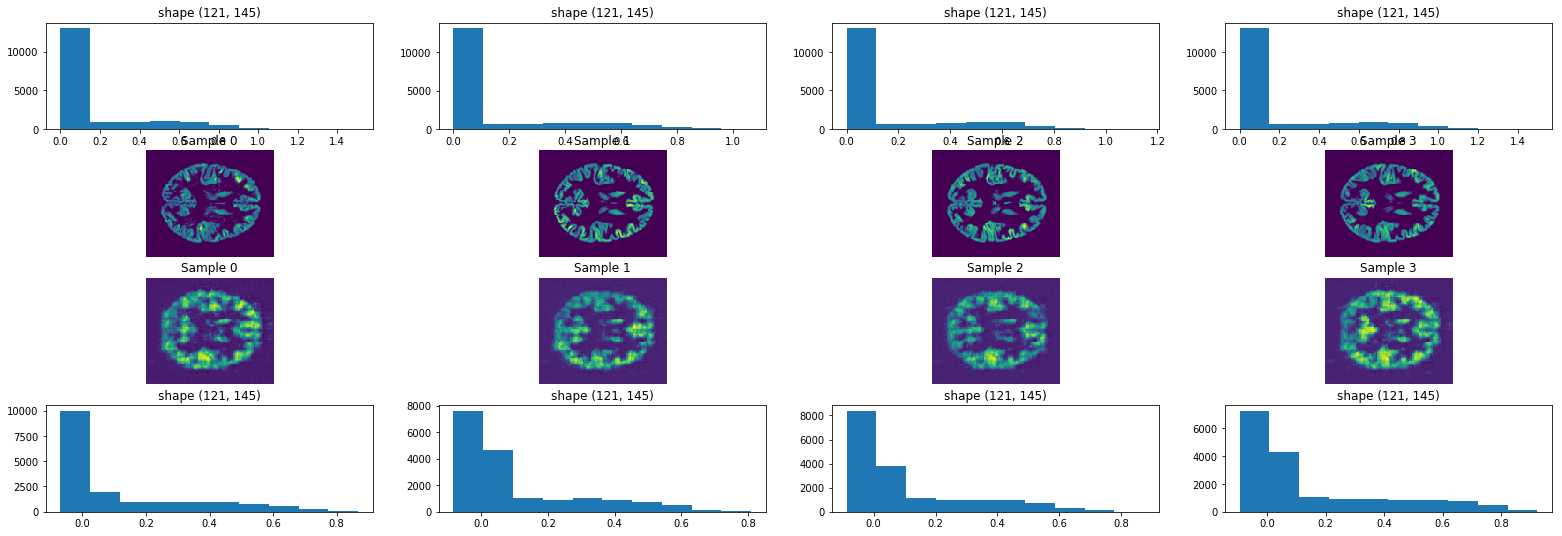

In [13]:
# face_dataset = FaceLandmarksDataset(csv_file='faces/face_landmarks.csv',
#                                     root_dir='faces/')
from matplotlib import pyplot as plt
from torch.autograd import Variable
fig = plt.figure(figsize=(12,12))

batch_size= 4
use_cuda = torch.cuda.is_available()
# for i in range(4): #len(datasets[0])):
figure = plt.figure(figsize=(27, 9))
i= 1
for batch_idx, inputs in enumerate(train_loader):    
    if batch_idx >= batch_size: 
        continue
    print("inputs shape", inputs.shape)
#     inputs = datasets['train'][i]
    print('min val for image:', i ,inputs.min())

#     inputs = inputs.view(inputs.size(0), -1).float()
    print(len(inputs))
    inputs.to(device)
#     if use_cuda:
#         inputs = inputs.cuda()
    inputs = Variable(inputs)
    outputs = model.forward(inputs)
#     f_sample = sdae.forward(datasets['train'][i])
#     sample = inputs.data.cpu().numpy().reshape(batch_size, 121,145)
    sample = inputs.data.cpu().numpy()[:4,0,:,:]
    sample_out = outputs.data.cpu().numpy()[:4,0,:,:] #.reshape(batch_size, 121,145)

    print(batch_idx, sample.shape)
i = 1
for b_idx in range(batch_size):

    ax = plt.subplot(4, 4, i)
    ax.set_title(f'shape {sample[b_idx].shape}')
#         ax.axis('off')
    ax.hist(sample[b_idx].flatten())
    i += 1

for b_idx in range(batch_size):

    ax = plt.subplot(4, 4, i)
    ax.set_title(f'Sample {b_idx}')
    ax.axis('off')
    ax.imshow(sample[b_idx])
    i += 1

for b_idx in range(batch_size):
    ax = plt.subplot(4, 4, i)
    ax.set_title(f'Sample {b_idx}')
    ax.axis('off')
    ax.imshow(sample_out[b_idx])
    i += 1

for b_idx in range(batch_size):

    ax = plt.subplot(4, 4, i)
    ax.set_title(f'shape {sample[b_idx].shape}')
#         ax.axis('off')
    ax.hist(sample_out[b_idx].flatten())
    i += 1

plt.show()

 

In [15]:
from udlp.clustering.vade_conv import VaDE
args_pretrain = 'model/pre_vade.pt'
args_pretrain = './conv_autoencoder1.pth'

in_features = 17545 # and we ignore this
out_features = 500 # we ignore this
pretrainepochs = 20 
epochs = 2
z_dim = 50 # currently we ignore this... or maybe we don't...

lr = 0.001

vade = VaDE(input_dim=in_features, z_dim=z_dim, n_centroids=3, binary=True,
        encodeLayer=[4000,1000,500], decodeLayer=[500,1000,4000], debug=True)

if args_pretrain != "":
    print("Loading model from %s..." % args_pretrain)
    vade.load_model(args_pretrain)
print("Initializing through GMM..")
data = vade.initialize_gmm(train_loader)

Loading model from ./conv_autoencoder1.pth...
encoder.0.weight torch.Size([16, 1, 3, 3])
encoder.0.bias torch.Size([16])
encoder.3.weight torch.Size([8, 16, 3, 3])
encoder.3.bias torch.Size([8])
decoder.0.weight torch.Size([8, 8, 2, 2])
decoder.0.bias torch.Size([8])
decoder.2.weight torch.Size([8, 16, 2, 2])
decoder.2.bias torch.Size([16])
decoder.4.weight torch.Size([16, 16, 3, 3])
decoder.4.bias torch.Size([16])
decoder.6.weight torch.Size([16, 1, 3, 3])
decoder.6.bias torch.Size([1])
ct1.weight torch.Size([8, 16, 3, 3])
ct1.bias torch.Size([16])
ct2.weight torch.Size([16, 8, 5, 5])
ct2.bias torch.Size([8])
ct3.weight torch.Size([8, 1, 2, 2])
ct3.bias torch.Size([1])
model dict **** 

theta_p torch.Size([3])
u_p torch.Size([50, 3])
lambda_p torch.Size([50, 3])
encoder.0.weight torch.Size([16, 1, 3, 3])
encoder.0.bias torch.Size([16])
encoder.3.weight torch.Size([8, 16, 3, 3])
encoder.3.bias torch.Size([8])
decoder.0.weight torch.Size([8, 8, 2, 2])
decoder.0.bias torch.Size([8])
deco

In [25]:
 vade.fit(train_loader, test_loader, 
          lr=lr, batch_size=batch_size, num_epochs=epochs,
          anneal=True, debug=False)

x.shape torch.Size([4, 1, 121, 145])
z size : torch.Size([4, 50])
outputs size : torch.Size([4, 1, 121, 145])
inputs size : torch.Size([4, 1, 121, 145])
mu size : torch.Size([4, 50])
p_c_z.shape = torch.Size([4, 3])
log_norm.max() = 0.9077073335647583
theta_tensor2.abs().max() 0.3333333432674408
gamma.shape = torch.Size([4, 3])
x.size() = torch.Size([4, 17545])
SSE.shape = torch.Size([4])
logpzc.shape = torch.Size([4])
qentropy.shape = torch.Size([4])
logpc.shape = torch.Size([4])
logqcx.shape = torch.Size([4])
x.shape torch.Size([4, 1, 121, 145])
z size : torch.Size([4, 50])
outputs size : torch.Size([4, 1, 121, 145])
inputs size : torch.Size([4, 1, 121, 145])
mu size : torch.Size([4, 50])
p_c_z.shape = torch.Size([4, 3])
log_norm.max() = 0.889747679233551
theta_tensor2.abs().max() 0.3333333432674408
gamma.shape = torch.Size([4, 3])
x.size() = torch.Size([4, 17545])
SSE.shape = torch.Size([4])
logpzc.shape = torch.Size([4])
qentropy.shape = torch.Size([4])
logpc.shape = torch.Size([4]

../udlp/clustering/vade_conv.py:537: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  valid_loss += loss.data[0] * len(inputs)


qentropy.shape = torch.Size([4])
logpc.shape = torch.Size([4])
logqcx.shape = torch.Size([4])
x.shape torch.Size([4, 1, 121, 145])
z size : torch.Size([4, 50])
outputs size : torch.Size([4, 1, 121, 145])
inputs size : torch.Size([4, 1, 121, 145])
mu size : torch.Size([4, 50])
p_c_z.shape = torch.Size([4, 3])
log_norm.max() = 0.882441520690918
theta_tensor2.abs().max() 0.3333333432674408
gamma.shape = torch.Size([4, 3])
x.size() = torch.Size([4, 17545])
SSE.shape = torch.Size([4])
logpzc.shape = torch.Size([4])
qentropy.shape = torch.Size([4])
logpc.shape = torch.Size([4])
logqcx.shape = torch.Size([4])
x.shape torch.Size([4, 1, 121, 145])
z size : torch.Size([4, 50])
outputs size : torch.Size([4, 1, 121, 145])
inputs size : torch.Size([4, 1, 121, 145])
mu size : torch.Size([4, 50])
p_c_z.shape = torch.Size([4, 3])
log_norm.max() = 0.8648068308830261
theta_tensor2.abs().max() 0.3333333432674408
gamma.shape = torch.Size([4, 3])
x.size() = torch.Size([4, 17545])
SSE.shape = torch.Size([4]

RuntimeError: input has less dimensions than expected

In [15]:
50688 / 145

349.57241379310346

In [23]:
t_ = torch.randn(3,4,5)
torch.mean(torch.mean(t_,0),0)


tensor([-0.0795, -0.1469, -0.0451,  0.5375,  0.3198])

In [19]:
t_

tensor([[[ 0.4731, -0.0053, -0.3319,  0.2713,  0.7005],
         [-1.8827, -2.1163, -1.0424,  0.6252, -1.7481],
         [-1.2485, -1.0145, -0.6190,  0.0970,  0.3495],
         [ 1.8528, -0.9753, -1.2327, -0.1826, -1.7579]],

        [[ 0.8002,  0.1315, -0.2851,  0.5646, -0.3113],
         [ 0.1716, -0.4437,  1.0584, -1.0507,  0.2160],
         [-1.3056,  1.9935,  2.0606, -0.8351,  1.9346],
         [ 0.0365,  1.6295,  0.0758, -1.6654,  1.1617]],

        [[-0.8955, -0.0863, -2.8041, -0.4501, -0.2374],
         [-0.2508, -0.9979,  1.6349,  2.0032,  0.1949],
         [ 0.0875,  0.5885, -0.7837, -1.4130, -0.2825],
         [ 1.0875,  0.0103,  0.3912,  0.0500,  0.3100]]])